# This notebook contains the cross validation experiment for log transformed data with lin reg, ridge reg, and lasso reg applied to it.

### Needed Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Setting up the style to make the plots look good.
plt.style.use('fivethirtyeight')

# Disabling the deprecation warnings because life is good. 
# import warnings
# def warn(*args, **kwargs):
#     pass
# warnings.warn = warn

### Combining and Removing Outliers
Our group each to a data range of our raw set and went through to generate the datapoints. Each of the files contain are individual data collection points so we need to combine them to retrieve the full set.

In [9]:
subset1 = pd.read_csv("datasets/freemont_2000-2005_dd_20180410-002554.csv")
subset2 = pd.read_csv("datasets/freemont_dd_20180411-170124")
subset3 = pd.read_csv("datasets/freemont_dd_20180410-213708")
full = pd.concat([subset1, subset2, subset3], ignore_index=True)
del full['Unnamed: 0']
len(full)

# Comparing the two datasets.
The two datasets share the same patterns.

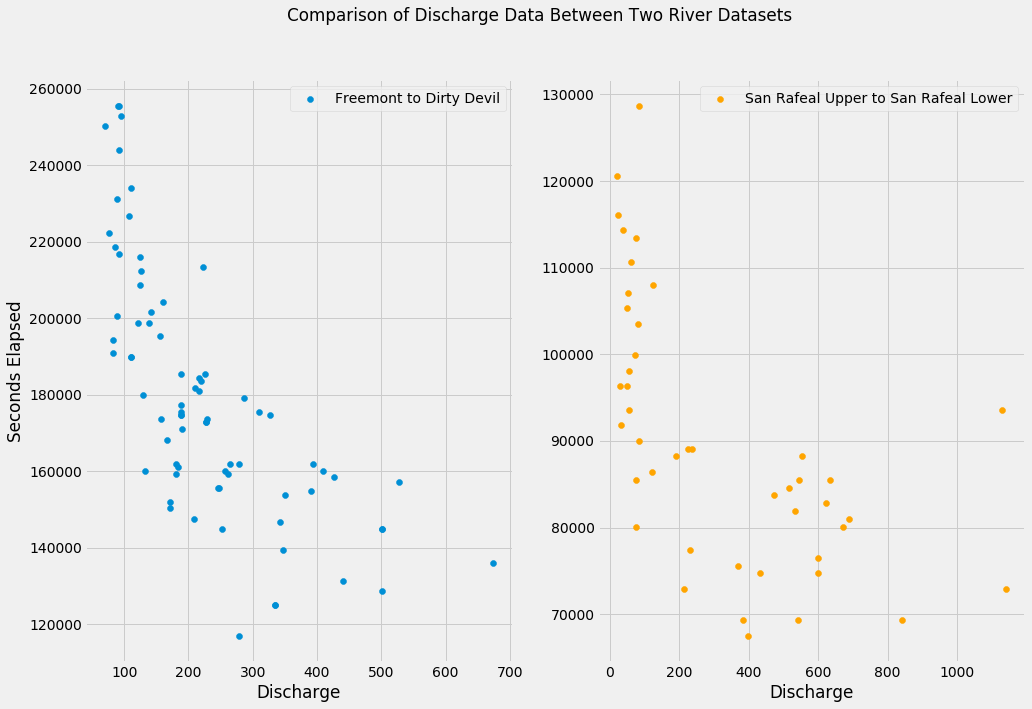

In [11]:
# San raf data
san_raf = pd.read_csv('datasets/s1=09328910_2000,s2=093285002015start-2016_dd_20180410-211609.csv')
san_raf_no_outerliers = san_raf[san_raf.secs_elapsed.between(65000, 300000)]
no_outliers = full[full.secs_elapsed.between(100000, 300000)]

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Comparison of Discharge Data Between Two River Datasets')
axs[0].scatter(no_outliers.free_discharge.values, no_outliers.secs_elapsed.values, label='Freemont to Dirty Devil')
axs[0].set_xlabel('Discharge')
axs[0].set_ylabel('Seconds Elapsed')
axs[0].legend()
axs[1].scatter(san_raf_no_outerliers.free_discharge.values, san_raf_no_outerliers.secs_elapsed.values, label='San Rafeal Upper to San Rafeal Lower', color='orange')
axs[1].set_xlabel('Discharge')
axs[1].legend()
plt.savefig('graphics/riv_comp.png')
plt.show()

### Seperating X and Y values.

In [13]:
no_log_y = no_outliers.secs_elapsed.values#san_raf_no_outerliers.secs_elapsed.values
no_log_x = no_outliers.free_discharge.values#san_raf_no_outerliers.free_discharge.values
no_log_x_range = np.arange(np.floor(no_log_x.min()), np.ceil(no_log_x.max()) +1)

In [14]:
Y = no_outliers.secs_elapsed.values
X = np.log(no_outliers.free_discharge.values)

Making x-range

In [15]:
x_range = np.arange(np.floor(X.min()), np.ceil(X.max()) +1)

#### Plot of the default values.

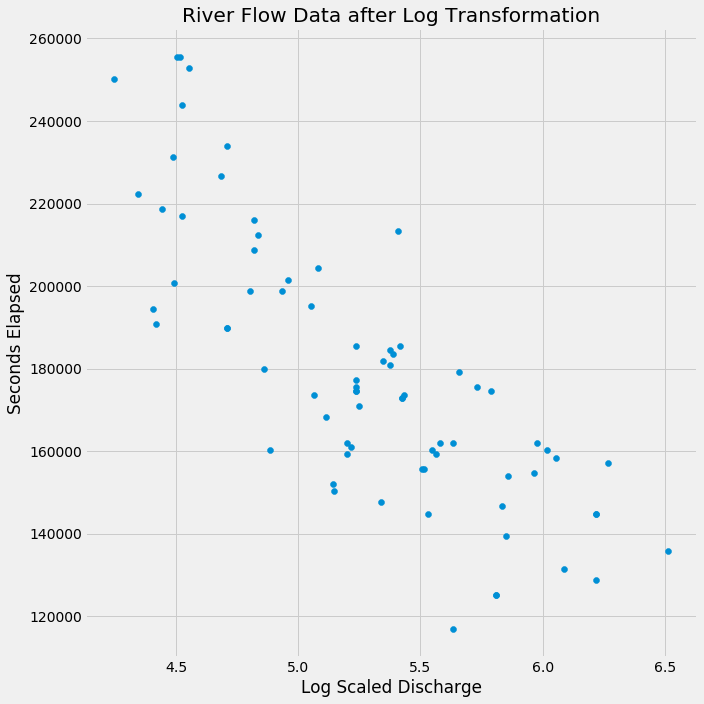

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.title('River Flow Data after Log Transformation')
plt.xlabel('Log Scaled Discharge')
plt.ylabel('Seconds Elapsed')
plt.tight_layout()
plt.savefig("graphics/log_scaled_discharge.png")
plt.show()

### Running Cross k-Fold Cross Validation to find the best parameters for Linear Regression Models

In [17]:
# Function to use to evaluate the score of the model
def score_func(estimator, X, y):
    return -1*np.linalg.norm(estimator.predict(X) - y, 2)

# # Function to use to evaluate the score of the model
# def score_func(estimator, X, y):
#     return -1*np.linalg.norm(estimator.predict(np.log(X)) - y, 2)

In [18]:
# Setting up pipeline so data is fed into the polynomial features before going into the regression.
lin_reg_pip = Pipeline([('regressor', LinearRegression())])

# Running the Cross Validation to search over the parameter space.
lin_reg_clf = GridSearchCV(lin_reg_pip, {},
                           cv=KFold(n_splits=5, shuffle=True, random_state=45), )
lin_reg_results = lin_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
lin_reg_results.grid_scores_

C:\Users\stone\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.56762, std: 0.17304, params: {}]

### Presenting the best estimator

In [19]:
lin_reg_results.best_estimator_

Pipeline(memory=None,
     steps=[('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### Plotting the linear model

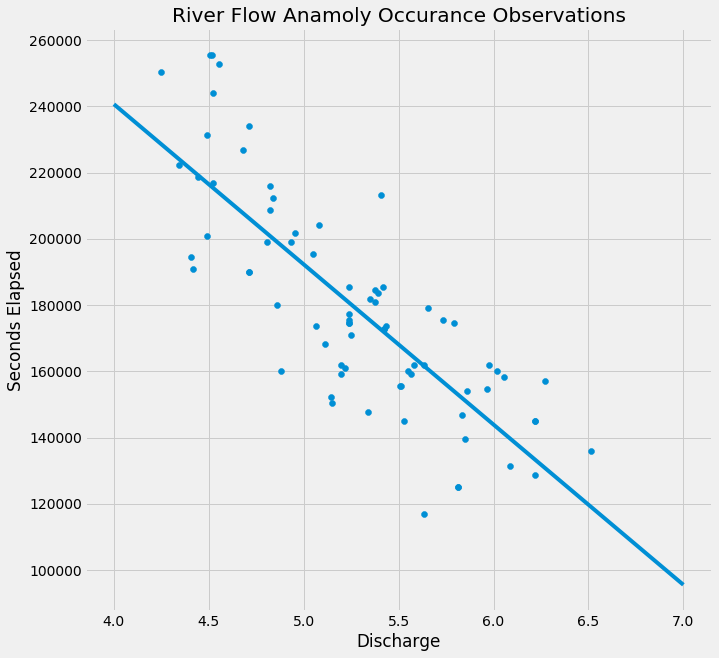

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, lin_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

# Running Cross k-Fold Cross Validation to find the best parameters for Ridge Regression Models

In [21]:
ridge_reg_clf = GridSearchCV(Ridge(),  {'alpha': [.0001, .001, .01, .1, 1, 10, 100]},
                             cv=KFold(n_splits=5, shuffle=True, random_state=45))
ridge_reg_results = ridge_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
ridge_reg_results.grid_scores_

C:\Users\stone\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.56762, std: 0.17304, params: {'alpha': 0.0001},
 mean: 0.56763, std: 0.17302, params: {'alpha': 0.001},
 mean: 0.56769, std: 0.17284, params: {'alpha': 0.01},
 mean: 0.56824, std: 0.17100, params: {'alpha': 0.1},
 mean: 0.57161, std: 0.15411, params: {'alpha': 1},
 mean: 0.51425, std: 0.07033, params: {'alpha': 10},
 mean: 0.14558, std: 0.04349, params: {'alpha': 100}]

#### Presenting the best ridge estimator

In [22]:
ridge_reg_results.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Plotting the ridge model

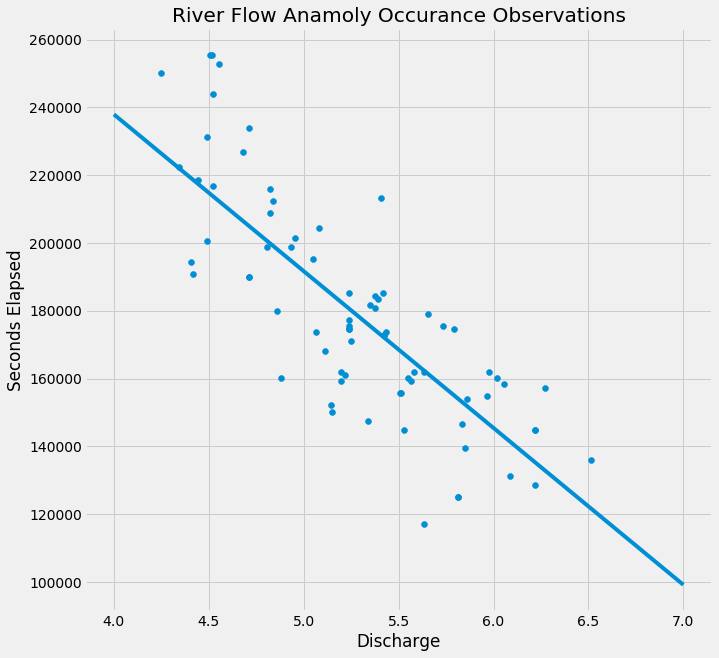

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, ridge_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

# Running Cross k-Fold Cross Validation to find the best parameters for Lasso Regression Models 

In [25]:
lasso_reg_pip.get_params()

NameError: name 'lasso_reg_pip' is not defined

In [26]:
lassor_reg_clf = GridSearchCV(Lasso(),  {'alpha': [.0001, .001, .01, .1, 1, 10, 100]}, 
                              cv=KFold(n_splits=5, shuffle=True, random_state=45))
lasso_reg_results = lassor_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
lasso_reg_results.grid_scores_

C:\Users\stone\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.56762, std: 0.17304, params: {'alpha': 0.0001},
 mean: 0.56762, std: 0.17304, params: {'alpha': 0.001},
 mean: 0.56762, std: 0.17304, params: {'alpha': 0.01},
 mean: 0.56762, std: 0.17304, params: {'alpha': 0.1},
 mean: 0.56763, std: 0.17302, params: {'alpha': 1},
 mean: 0.56769, std: 0.17280, params: {'alpha': 10},
 mean: 0.56828, std: 0.17059, params: {'alpha': 100}]

### Presenting the best ridge model

In [27]:
lasso_reg_results.best_estimator_

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

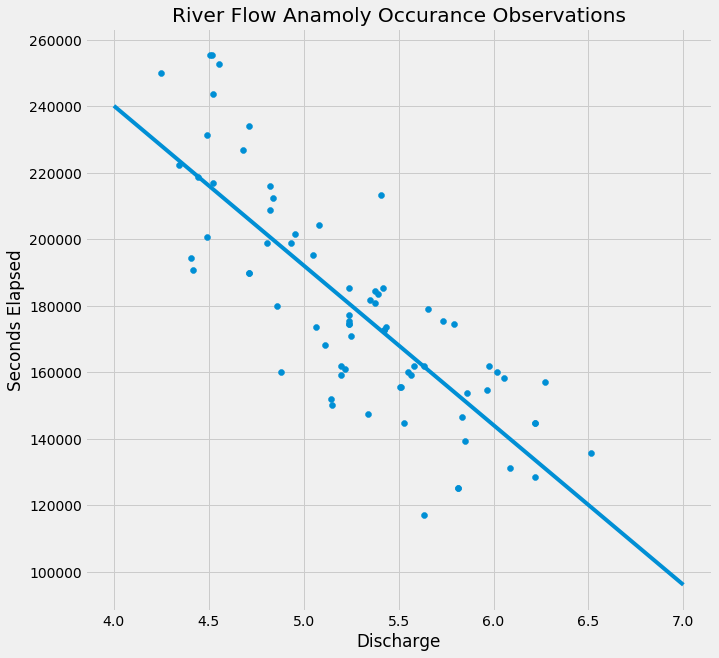

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, lasso_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

## Plotting all the best models.

As we can see the models are very similar. The two models with regularizers (ridge, and lasso) dont seem to be providing much of a benefit.

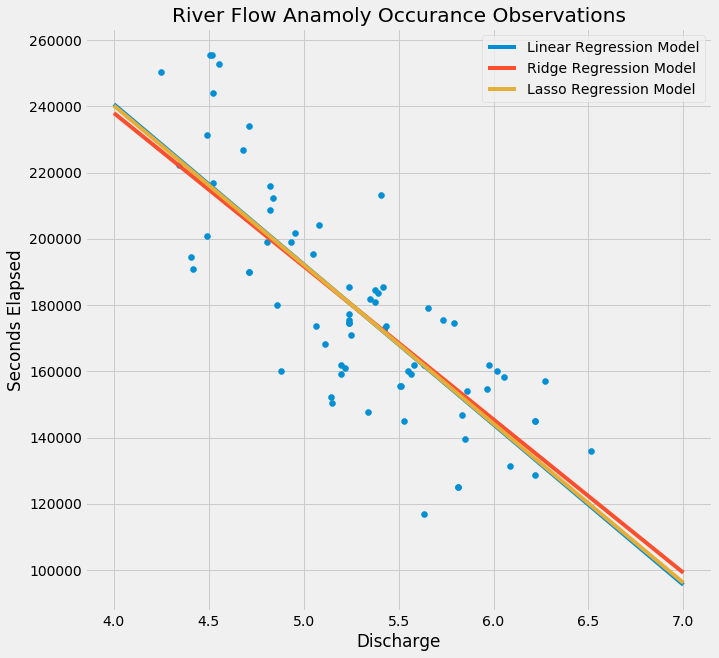

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, lin_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Linear Regression Model')
plt.plot(x_range, ridge_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Ridge Regression Model')
plt.plot(x_range, lasso_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Lasso Regression Model')
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.legend()
plt.show()

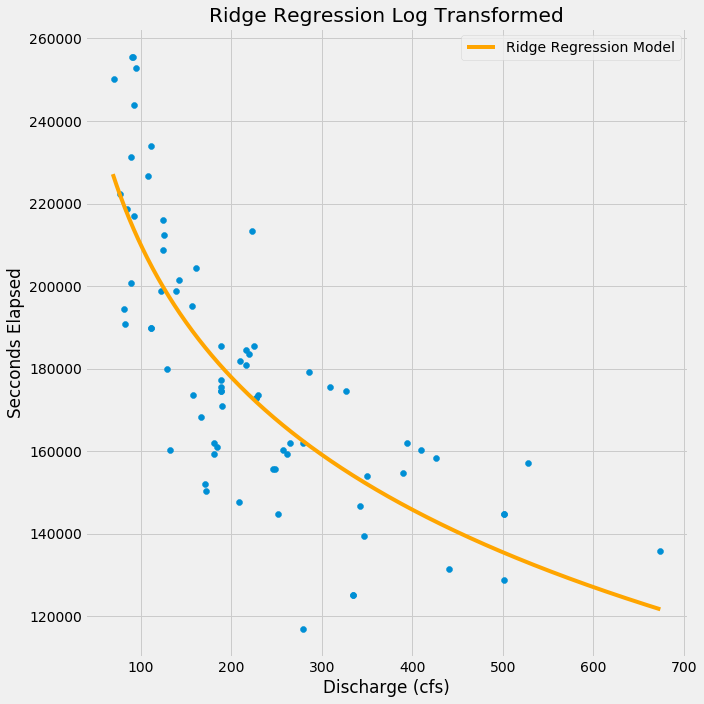

In [33]:
plt.figure(figsize=(10, 10))
#plt.scatter(no_log_x, no_log_y)
#plt.plot(no_log_x_range, lin_reg_results.best_estimator_.predict(np.log(no_log_x_range[:,np.newaxis])), label='Linear Regression Model')
plt.scatter(no_log_x,no_log_y)
plt.plot(no_log_x_range, ridge_reg_results.best_estimator_.predict(np.log(no_log_x_range[:,np.newaxis])), label='Ridge Regression Model',
        color='orange')
#plt.plot(no_log_x_range, lasso_reg_results.best_estimator_.predict(np.log(no_log_x_range[:,np.newaxis])), label='Lasso Regression Model')
plt.title('Ridge Regression Log Transformed')
plt.xlabel('Discharge (cfs)')
plt.ylabel('Secconds Elapsed')
plt.legend()
plt.tight_layout()
plt.savefig("graphics/free_log-scaled.png")
plt.show()

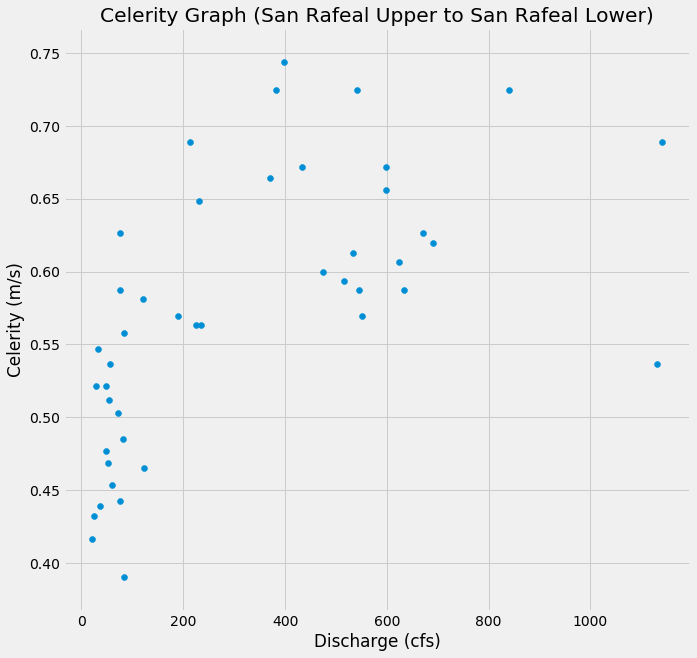

In [31]:
fig = plt.figure(figsize=(10,10))
plt.title('Celerity Graph (San Rafeal Upper to San Rafeal Lower)')
plt.xlabel('Discharge (cfs)')
plt.ylabel('Celerity (m/s)')
plt.scatter(san_raf_no_outerliers.free_discharge.values, 50211.53  /san_raf_no_outerliers.secs_elapsed.values)
plt.savefig('graphics/celerity.png')